# GitHub Community Health

In [1]:
from scipy.io import arff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn import tree
import graphviz

# Models
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import AgglomerativeClustering, KMeans

In [2]:
# Apply label encoder to categorical columns
# Return indices of those columns
def categorical_to_numberic(df):
    cols, indices = [], []
    for i, col in enumerate(df):
        if isinstance(df[col][0], bytes):
            cols.append(col)
            indices.append(i)
    atts = [col for col in df if isinstance(df[col][0], bytes)]
    df[cols] = df[cols].apply(LabelEncoder().fit_transform)
    return indices

In [10]:
# Load arff file into pandas dataframe
data = arff.loadarff("github.arff")
df = pd.DataFrame(data[0])

# Delete features
# del df["forks_count"]
del df["seconds_since_updated"]
del df["seconds_since_pushed"]

# Convert categorical data to numeric
cat_cols = categorical_to_numberic(df)

# Impute missing values
df.replace("?", np.NaN, inplace=True)
imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
idf = pd.DataFrame(imputer.fit_transform(df))
idf.columns = df.columns
idf.index = df.index

# Split off collumn we want to predict
predict_attribute = "contributor_count"
X_df = idf.drop(predict_attribute, axis=1)
y_df = idf[predict_attribute]

# Normalize inputs, convert to numpy
X = MinMaxScaler().fit_transform(X_df)
y = y_df.to_numpy()
y_log = np.log(y)
print("Contributor count statistics")
print(pd.DataFrame(y).describe())
print("\nContributor count (logged) statistics")
print(pd.DataFrame(y_log).describe())

Contributor count statistics
                  0
count  10000.000000
mean      27.007700
std       85.154676
min        1.000000
25%        1.000000
50%        1.000000
75%       13.000000
max      988.000000

Contributor count (logged) statistics
                  0
count  10000.000000
mean       1.360771
std        1.734924
min        0.000000
25%        0.000000
50%        0.000000
75%        2.564949
max        6.895683


Split into trainig and testing datasets

In [11]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8500, 36) (1500, 36) (8500,) (1500,)


Taking log10 of data makes regressions a much easier task

In [12]:
y_log_train, y_log_test = np.log10(y_train), np.log10(y_test)

Split off a sample of the data set to speed up feature analysis

In [13]:
# Randomly sample from the data set
selection = np.random.randint(1, len(X), 500)
X_sample = X[selection]
y_sample = y_log[selection]

# Split sample into train and test sets
X_sample_train, X_sample_test, y_sample_train, y_sample_test = train_test_split(X_sample, y_sample, test_size=0.3)
print(X_sample_train.shape, X_sample_test.shape, y_sample_train.shape, y_sample_test.shape)

(350, 36) (150, 36) (350,) (150,)


## Feature Analysis

Compute the mean and the baseline error for contributor count and the log of it

In [14]:
mean = np.mean(y)
print(f"Baseline error: {mean_absolute_error(np.full_like(y, mean), y)}")
mean_log = np.mean(y_log)
print(f"Log baseline error: {mean_absolute_error(np.full_like(y_log, mean_log), y_log)}")

Baseline error: 38.274897499999994
Log baseline error: 1.4721730182723436


In [15]:
# Plot with n best features
def view_pred(n, n_pred, n_feats):
    pred = n_pred[n]
    print(*[col for col in df.columns[:-1][n_feats[n]]], sep="  ")
    plt.plot(pred, label="Prediction")
    plt.plot(y_sample_test, label="True")
    plt.title(f"{n} best features")
    plt.legend()
    plt.show()

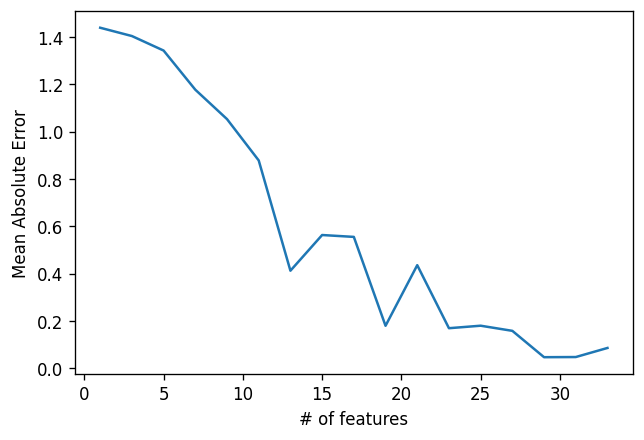

In [16]:
# Sequential feature selection
# Define custom distance metric to handle numeric and categorical data
def my_dist(x, y, cat_cols=[]):
    total = 0
    for i, feature in enumerate(x):
        if i not in cat_cols:
            total += np.abs(feature - y[i])
        elif feature != y[i]:
            total += 0.5
    return total

# regr = KNeighborsRegressor(metric=my_dist, metric_params={"cat_cols": cat_cols})
# regr = MLPRegressor(max_iter=10000)
regr = DecisionTreeRegressor(max_depth=10)
domain = np.arange(1, 35, 2)
n_err = {}
n_pred = {}
n_feats = {}

for i, n in enumerate(domain):
    
    sfs = SequentialFeatureSelector(regr, n_features_to_select=int(n), direction="forward")
    sfs.fit(X_sample_train, y_sample_train)
    feats = sfs.get_support()
    n_feats[n] = feats
    X_reduce = X_sample_test.T[feats].T
    
    regr.fit(X_reduce, y_sample_test)
    pred = regr.predict(X_reduce)
    n_pred[n] = pred
    err = mean_absolute_error(y_sample_test, pred)
    n_err[n] = err

# Plot n vs err
plt.rcParams["figure.dpi"] = 120
plt.plot(domain, n_err.values())
plt.xlabel("# of features")
plt.ylabel("Mean Absolute Error")
plt.savefig("feature_selection.png", dpi=300)
plt.show()

View how well the best prediction did

has_issues  has_projects  has_downloads  has_pages  topics_count  has_contributing  has_support_file  has_funding_file  has_codeowners  has_changelog  has_codespaces  has_discussions  labels_count


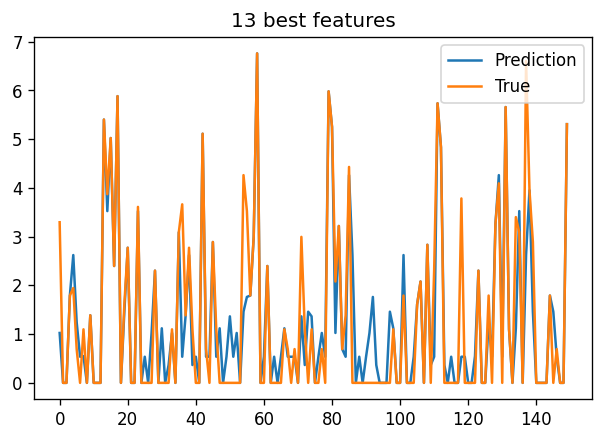

In [17]:
view_pred(13, n_pred, n_feats)

Reduce our dataset to the features these features that preformed best

In [91]:
feats = n_feats[27]
X_train = X_train.T[feats].T
X_test = X_test.T[feats].T
print(X_train.shape, X_test.shape)

(8500, 27) (1500, 27)


## Regression

### PCA
Most of the variation in the data can be compressed to ~6 dimentions/features.

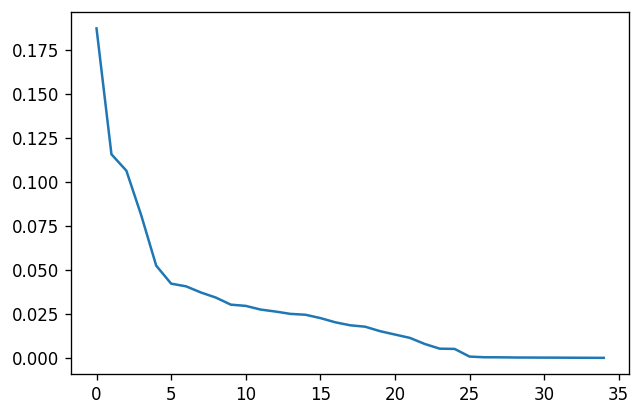

In [93]:
pca = PCA(n_components=35)
pca.fit(X)
plt.plot(pca.explained_variance_ratio_)
plt.savefig("pca.png", dpi=300)
plt.plot()

pca = PCA(n_components=5)
X_pca_train = pca.fit_transform(X_train)
X_pca_test = pca.fit_transform(X_test)

### K-Nearest Neighbors

Error: 0.6138631269503059


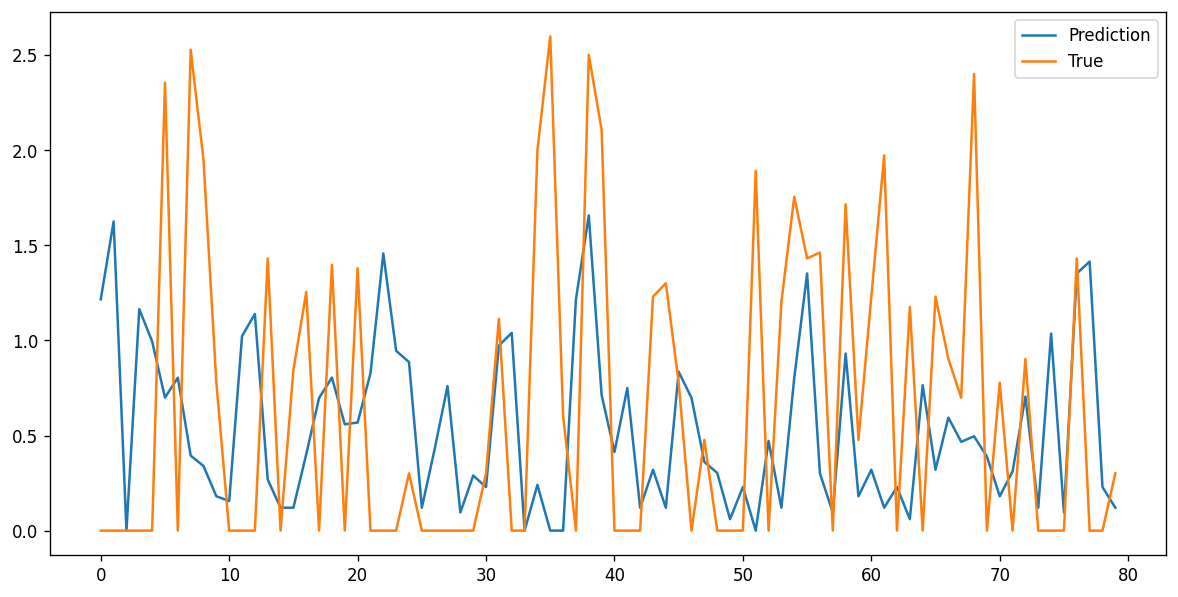

In [94]:
knn = KNeighborsRegressor(metric=my_dist, metric_params={"cat_cols": cat_cols})
knn.fit(X_pca_train, y_log_train)
pred = knn.predict(X_pca_test)
err = mean_absolute_error(y_log_test, pred)
print(f"Error: {err}")
plt.figure(figsize=(12,6))
selection = np.random.randint(1, len(pred), 80)
plt.plot(pred[selection], label="Prediction")
plt.plot(y_log_test[selection], label="True")
plt.legend()
plt.savefig("knn.png", dpi=300)
plt.show()

### Multilayer Perceptron

### Decision Tree
The decision tree starts to overfit after 7 layers. It does much better then Knn.

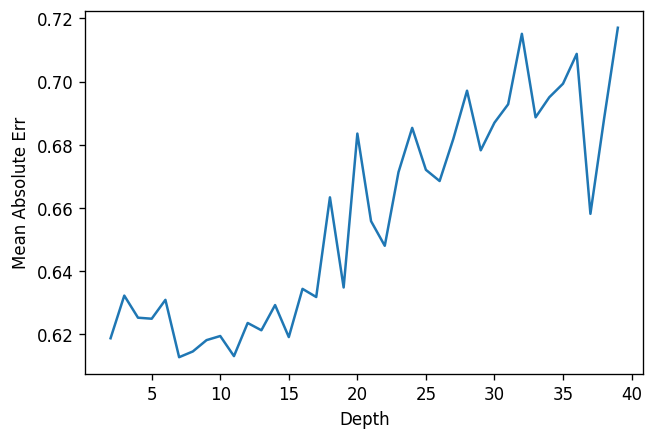

Error: 0.610731664645346


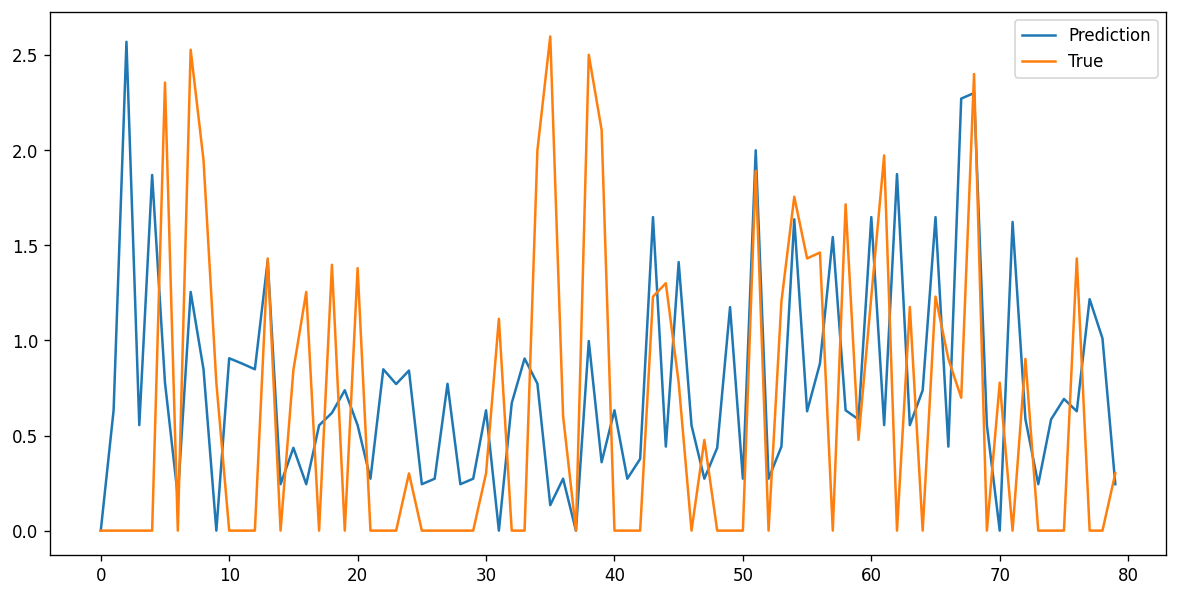

In [95]:
# max_features <- The number of features to consider when looking for the best split

dom = np.arange(2, 40)
errs = []
for i in dom:
    decisionTree = DecisionTreeRegressor(max_depth=i, max_features=1)
    decisionTree.fit(X_train, y_log_train)
    pred = decisionTree.predict(X_test)
    err = mean_absolute_error(y_log_test, pred)
    errs.append(err)
plt.plot(dom, errs)
plt.xlabel("Depth")
plt.ylabel("Mean Absolute Err")
plt.savefig("depth_error.png", dpi=300)
plt.show()

decisionTree = DecisionTreeRegressor(max_depth=10)
decisionTree.fit(X_train, y_log_train)
pred = decisionTree.predict(X_test)
err = mean_absolute_error(y_log_test, pred)
print(f"Error: {err}")
plt.figure(figsize=(12,6))
plt.plot(pred[selection], label="Prediction")
plt.plot(y_log_test[selection], label="True")
plt.legend()
plt.savefig("decision_tree.png", dpi=300)
plt.show()

In [105]:
tree_data = tree.export_graphviz(decisionTree,
                                 feature_names=X_df.T[feats].T.columns,
                                 out_file=None, 
                                 filled=True, 
                                 max_depth=3)
graphviz.Source(tree_data, format="png").render("tree.png")

'tree.png.png'

## Clustering

### Kmeans, HAC
The Silhouette score is quite good, especially for k=2. The cluster sizes are also somewhat reasonable. My guess is that it basically partitioned the ~2.5% of the repos with > 100 contributors.

2 k-means cluster sizes: [9746  254]
2 HAC single cluster sizes: [  15 9985]
2 HAC complete cluster sizes: [9925   75]
3 k-means cluster sizes: [9349  131  520]
3 HAC single cluster sizes: [  14 9985    1]
3 HAC complete cluster sizes: [  75  312 9613]
4 k-means cluster sizes: [9067  178   95  660]
4 HAC single cluster sizes: [9985   13    1    1]
4 HAC complete cluster sizes: [ 312   60 9613   15]
5 k-means cluster sizes: [8822  119   60  744  255]
5 HAC single cluster sizes: [  13 9957    1    1   28]
5 HAC complete cluster sizes: [  60  256 9613   15   56]


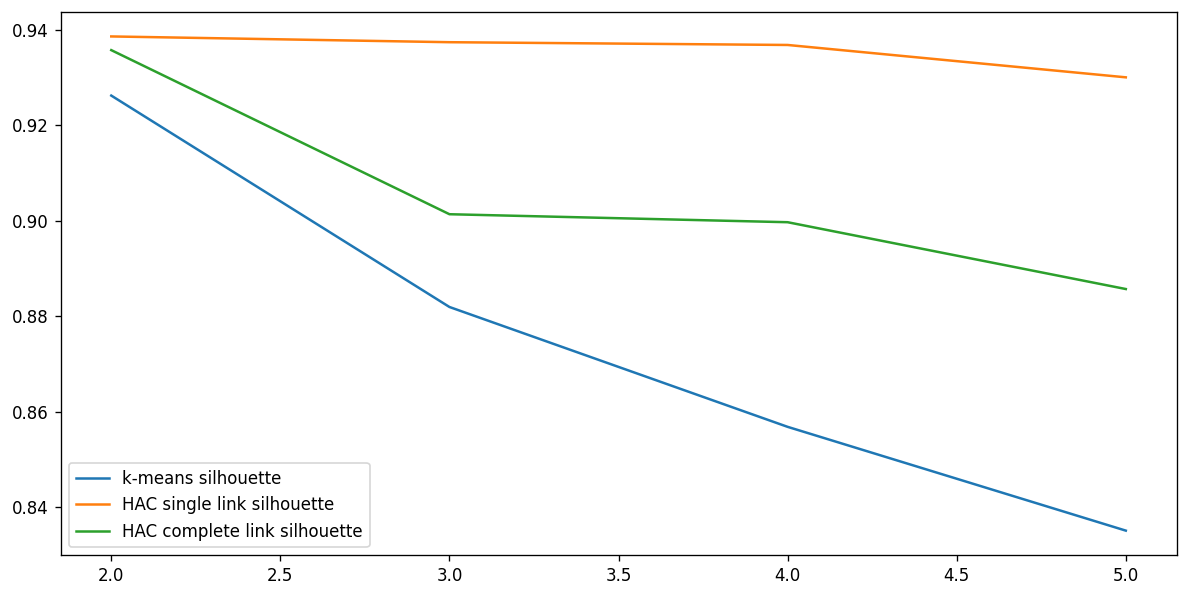

In [106]:
kmeans_sil, single_sil, complete_sil = [], [], []
data = np.column_stack((X, y))
dom = np.arange(2, 6)
for k in dom:
    # K-means
    kmeans = KMeans(n_clusters=k)
    kmeans_clusters = kmeans.fit_predict(data)
    print(f"{k} k-means cluster sizes: {np.unique(kmeans_clusters, return_counts=True)[1]}")
    kmeans_sil.append(silhouette_score(data, kmeans_clusters))
    
    # HAC single
    hac_single = AgglomerativeClustering(n_clusters=k, linkage="single")
    hac_single_clusters = hac_single.fit_predict(data)
    print(f"{k} HAC single cluster sizes: {np.unique(hac_single_clusters, return_counts=True)[1]}")
    single_sil.append(silhouette_score(data, hac_single_clusters))
    
    # HAC complete
    hac_complete = AgglomerativeClustering(n_clusters=k, linkage="complete")
    hac_complete_clusters = hac_complete.fit_predict(data)
    print(f"{k} HAC complete cluster sizes: {np.unique(hac_complete_clusters, return_counts=True)[1]}")
    complete_sil.append(silhouette_score(data, hac_complete_clusters))

plt.figure(figsize=(12, 6))
plt.plot(dom, kmeans_sil, label="k-means silhouette")
plt.plot(dom, single_sil, label="HAC single link silhouette")
plt.plot(dom, complete_sil, label="HAC complete link silhouette")
plt.legend()
plt.savefig("clusters_silhouette.png", dpi=300)
plt.show()

Analysis regarding the k-means clusters for k=2

In [20]:
kmeans = KMeans(n_clusters=2)
clusters = kmeans.fit_predict(data)
unique, counts = np.unique(clusters, return_counts=True)
for label in unique:
    cluster_points = data[clusters == label]
    avg_pd = pd.DataFrame(cluster_points)
    avg_pd.columns = df.columns
    print(f"\n\n\nCluster size: {counts[label]}\n")
    print(avg_pd.describe())
print(f"Silhouette: {silhouette_score(data, clusters)}")




Cluster size: 9746

       seconds_since_created  seconds_since_updated  seconds_since_pushed  \
count            9746.000000            9746.000000           9746.000000   
mean                0.249989               0.787730              0.787644   
std                 0.198801               0.303551              0.303511   
min                 0.000000               0.000000              0.000000   
25%                 0.090748               0.830840              0.830946   
50%                 0.197083               0.906505              0.906332   
75%                 0.373395               0.967309              0.967310   
max                 1.000000               1.000000              1.000000   

              size  stargazers_count  watchers_count  primary_language  \
count  9746.000000       9746.000000     9746.000000       9746.000000   
mean      0.002632          0.003807        0.003807          0.463739   
std       0.022400          0.020920        0.020920         

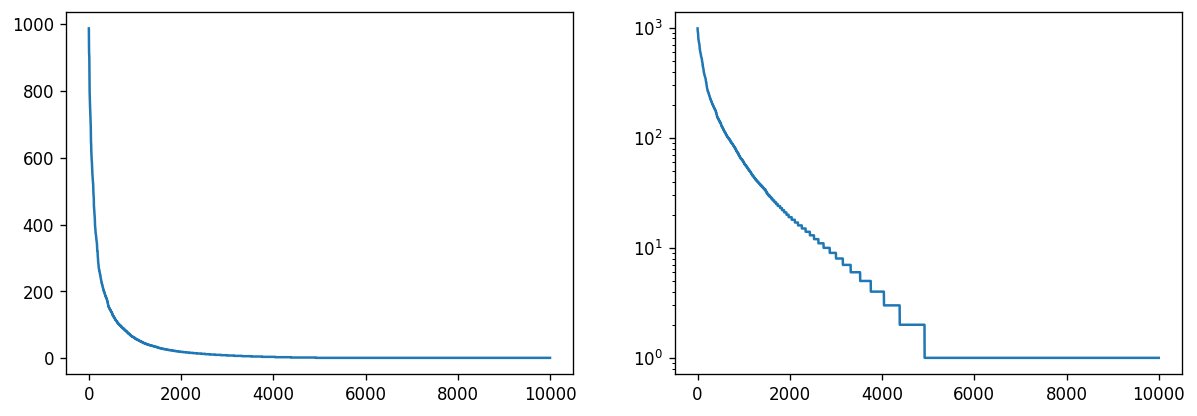

In [107]:
sorted_y = np.sort(y)[::-1]
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(sorted_y)
plt.subplot(122)
plt.semilogy(sorted_y)
plt.savefig("contributor_distribution.png", dpi=300)
plt.show()

boosting, throw out seconds since last update.